In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report
import joblib
import shap
from sklearn.metrics import f1_score
import re
import seaborn as sns
shap.initjs()
import sys
from itertools import combinations
sys.path.append('./scrape.py')
import scrape
import networkx as nx
from matplotlib import cm

os.chdir("../../Dataset/Merged")

dataset = pd.read_csv('MergedDatasetZeroes.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

ensembleSelected = joblib.load('../../Modelli/DatasetZeroes/ensembleSelected_39.pkl')

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])
x_train = x_train[list(ensembleSelected.feature_names_in_)]

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])
x_test = x_test[list(ensembleSelected.feature_names_in_)]

x_train = x_train[ensembleSelected.feature_names_in_]
x_test = x_test[ensembleSelected.feature_names_in_]

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


C:\Users\samue\AppData\Roaming\Python\Python311\site-packages\combat\pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data
Dataset di train:
(1593, 12094)
I malati sono:  695
I sani sono:  898

Dataset di test:
(520, 12094)
I malati sono:  245
I sani sono:  275


In [2]:
print(ensembleSelected.score(x_train, y_train))
print(ensembleSelected.score(x_test, y_test))
print(classification_report(y_test, ensembleSelected.predict(x_test)))

1.0
0.948076923076923
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       275
           1       0.92      0.98      0.95       245

    accuracy                           0.95       520
   macro avg       0.95      0.95      0.95       520
weighted avg       0.95      0.95      0.95       520



<h1> Shap Values </h1>

In [2]:
shap_object = joblib.load('../../ShapValues/DatasetZeroes/ensembleSelected_shapValues.pkl')
shap_values = shap_object.values
shap_importance = np.abs(shap_values).mean(0)
shap_dict = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_dictSummary = dict(zip(ensembleSelected.feature_names_in_, shap_importance))
expl_sorted = dict(sorted(expl_dictSummary.items(), key=lambda item: item[1], reverse=True))

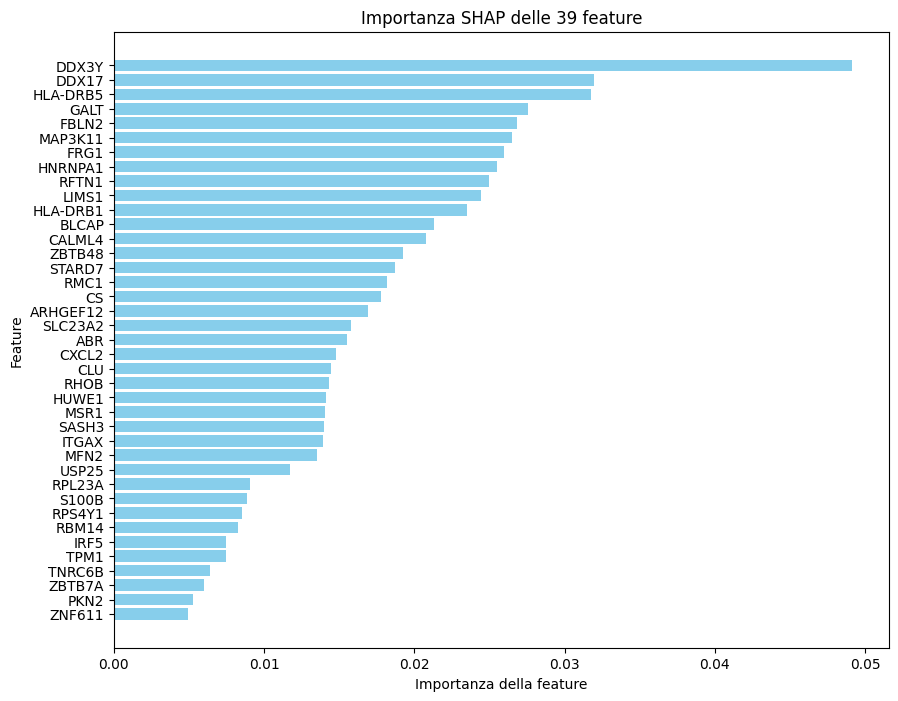

In [13]:
plt.figure(figsize=(10, 8))
plt.barh(list(expl_sorted.keys())[:][::-1], list(expl_sorted.values())[:][::-1], color='skyblue')
plt.xlabel('Importanza della feature')
plt.ylabel('Feature')
plt.title('Importanza SHAP delle 39 feature')
plt.show()

<h1>Ablation</h1>

In [148]:
def calcScores(x_test, y_test, model):
    scores = {col: 0 for col in x_test.columns}
    i = 1
    for exclude in range(x_train.shape[1]):
        x = x_test.copy()
        x[x.columns[exclude]] = x[x.columns[exclude]].mean()
        scores[x.columns[exclude]] = f1_score(y_test, model.predict(x))
        print(i)
        i += 1
    return scores

scores = calcScores(x_test, y_test, ensembleSelected)
joblib.dump(scores, '../../ShapValues/DatasetZeroes/ensembleSelected_ablationScoresPURI.pkl')

original = f1_score(y_test, ensembleSelected.predict(x_test))
new_scores = {key: original/value for key, value in scores.items()}
joblib.dump(new_scores, '../../ShapValues/DatasetZeroes/ensembleSelected_ablationScores.pkl')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [16]:
scores = joblib.load('../../ShapValues/DatasetZeroes/ensembleSelected_ablationScoresPURI.pkl')
print(scores)

{'DDX3Y': 0.9446640316205535, 'HLA-DRB5': 0.9395711500974658, 'HNRNPA1': 0.9484126984126985, 'HLA-DRB1': 0.9428007889546351, 'ITGAX': 0.9465346534653466, 'RFTN1': 0.9446640316205535, 'LIMS1': 0.9446640316205535, 'CS': 0.9465346534653466, 'SLC23A2': 0.9465346534653466, 'CALML4': 0.9465346534653466, 'MAP3K11': 0.9465346534653466, 'S100B': 0.9446640316205535, 'HUWE1': 0.9482071713147411, 'CLU': 0.9465346534653466, 'MFN2': 0.9502982107355865, 'CXCL2': 0.9465346534653466, 'STARD7': 0.9465346534653466, 'IRF5': 0.9465346534653466, 'RPS4Y1': 0.9465346534653466, 'RBM14': 0.9465346534653466, 'RHOB': 0.9465346534653466, 'RMC1': 0.9446640316205535, 'USP25': 0.9465346534653466, 'MSR1': 0.9465346534653466, 'ABR': 0.9465346534653466, 'SASH3': 0.9465346534653466, 'DDX17': 0.9444444444444445, 'ARHGEF12': 0.9446640316205535, 'PKN2': 0.9465346534653466, 'TPM1': 0.9444444444444445, 'FRG1': 0.9463220675944334, 'ZBTB48': 0.9463220675944334, 'GALT': 0.9461077844311377, 'FBLN2': 0.9425742574257425, 'TNRC6B': 

In [3]:
new_scores = joblib.load('../../ShapValues/DatasetZeroes/ensembleSelected_ablationScores.pkl')
sorted_scores = dict(sorted(new_scores.items(), key=lambda item: item[1], reverse=True))
bestFeatures = {key: value for key, value in sorted_scores.items() if value > 1.0}
worstFeatures = {key: value for key, value in sorted_scores.items() if value < 1.0}
print("Le feature migliori sono: ", len(bestFeatures), bestFeatures)
print("Le feature rumorose sono: ", len(worstFeatures), worstFeatures)

print(list(bestFeatures.keys()))

Le feature migliori sono:  16 {'HLA-DRB5': 1.0074113635429933, 'FBLN2': 1.0042016806722691, 'HLA-DRB1': 1.003960396039604, 'DDX17': 1.0022131624927197, 'TPM1': 1.0022131624927197, 'ZNF611': 1.0022131624927197, 'DDX3Y': 1.001980198019802, 'RFTN1': 1.001980198019802, 'LIMS1': 1.001980198019802, 'S100B': 1.001980198019802, 'RMC1': 1.001980198019802, 'ARHGEF12': 1.001980198019802, 'GALT': 1.0004511843589423, 'FRG1': 1.0002246443131708, 'ZBTB48': 1.0002246443131708, 'TNRC6B': 1.0002246443131708}
Le feature rumorose sono:  3 {'HUWE1': 0.9982361261336218, 'HNRNPA1': 0.998019801980198, 'MFN2': 0.996039603960396}
['HLA-DRB5', 'FBLN2', 'HLA-DRB1', 'DDX17', 'TPM1', 'ZNF611', 'DDX3Y', 'RFTN1', 'LIMS1', 'S100B', 'RMC1', 'ARHGEF12', 'GALT', 'FRG1', 'ZBTB48', 'TNRC6B']


<h1>Matrici di correlazione</h1>

Correlazione tra migliori 100 shap values sulla matrice di importanze

In [4]:
ensembleCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()
print(ensembleCorr)

             DDX3Y     DDX17  HLA-DRB5      GALT     FBLN2   MAP3K11  \
DDX3Y     1.000000  0.173252  0.448708  0.353928  0.075174  0.517446   
DDX17     0.173252  1.000000  0.065063  0.004216  0.095651  0.135803   
HLA-DRB5  0.448708  0.065063  1.000000  0.234969  0.040502  0.166137   
GALT      0.353928  0.004216  0.234969  1.000000  0.043685  0.086829   
FBLN2     0.075174  0.095651  0.040502  0.043685  1.000000  0.074021   
MAP3K11   0.517446  0.135803  0.166137  0.086829  0.074021  1.000000   
FRG1      0.368510  0.064363  0.312098  0.214916  0.150831  0.122779   
HNRNPA1   0.407457 -0.025018  0.421824  0.261360  0.050795  0.091846   
RFTN1     0.800962  0.171991  0.415958  0.272903  0.083333  0.548615   
LIMS1     0.589937  0.122334  0.296628  0.216823  0.116893  0.314645   
HLA-DRB1  0.196876  0.083475  0.657988  0.090576 -0.036439  0.128071   
BLCAP     0.586232  0.181008  0.197607  0.061562  0.184266  0.453886   
CALML4    0.748948  0.119743  0.358186  0.270683  0.094175  0.47

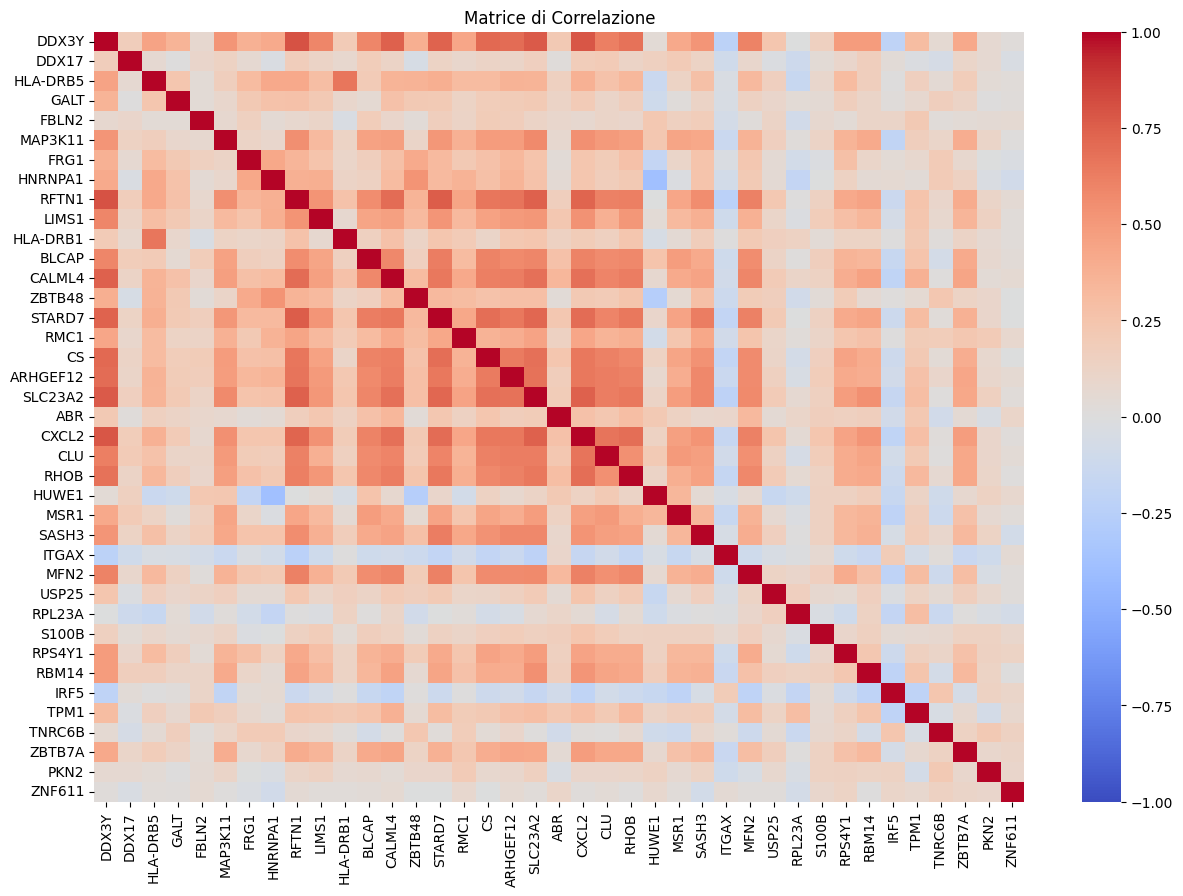

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(ensembleCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [5]:
ensemble_correlated_pairs = np.where(np.abs(ensembleCorr) >= 0.4)

# Print the correlated pairs
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        print(f"{ensembleCorr.index[i]} - {ensembleCorr.columns[j]}: {ensembleCorr.iloc[i, j]}")

retrieveGenes = []
for i, j in zip(ensemble_correlated_pairs[0], ensemble_correlated_pairs[1]):
    if i != j:
        if ensembleCorr.index[i] not in retrieveGenes:
            retrieveGenes.append(ensembleCorr.index[i])

print(retrieveGenes)

DDX3Y - HLA-DRB5: 0.44870776622522096
DDX3Y - MAP3K11: 0.5174463742663071
DDX3Y - HNRNPA1: 0.4074567160994127
DDX3Y - RFTN1: 0.8009619061046651
DDX3Y - LIMS1: 0.589936533673424
DDX3Y - BLCAP: 0.5862321669003573
DDX3Y - CALML4: 0.7489483883434663
DDX3Y - STARD7: 0.7412501319288394
DDX3Y - RMC1: 0.43285401219220904
DDX3Y - CS: 0.7127831793072186
DDX3Y - ARHGEF12: 0.7004801930462589
DDX3Y - SLC23A2: 0.7676359495544187
DDX3Y - CXCL2: 0.7871623371035981
DDX3Y - CLU: 0.6193850862138485
DDX3Y - RHOB: 0.6776541397168035
DDX3Y - MSR1: 0.4168714711672217
DDX3Y - SASH3: 0.5218642541056545
DDX3Y - MFN2: 0.6038040355016878
DDX3Y - RPS4Y1: 0.4878978926463848
DDX3Y - RBM14: 0.4878889671265189
DDX3Y - ZBTB7A: 0.41544758795775066
HLA-DRB5 - DDX3Y: 0.44870776622522096
HLA-DRB5 - HNRNPA1: 0.42182371652847683
HLA-DRB5 - RFTN1: 0.4159582130968884
HLA-DRB5 - HLA-DRB1: 0.657987584132758
MAP3K11 - DDX3Y: 0.5174463742663071
MAP3K11 - RFTN1: 0.5486148841770295
MAP3K11 - BLCAP: 0.4538856970025632
MAP3K11 - CALML

Correlazione tra intersezione migliori shap e ablation

{'HLA-DRB5', 'RFTN1', 'TNRC6B', 'S100B', 'DDX3Y', 'LIMS1', 'ARHGEF12', 'FBLN2', 'RMC1', 'HLA-DRB1', 'TPM1', 'DDX17', 'ZBTB48', 'GALT', 'ZNF611', 'FRG1'}


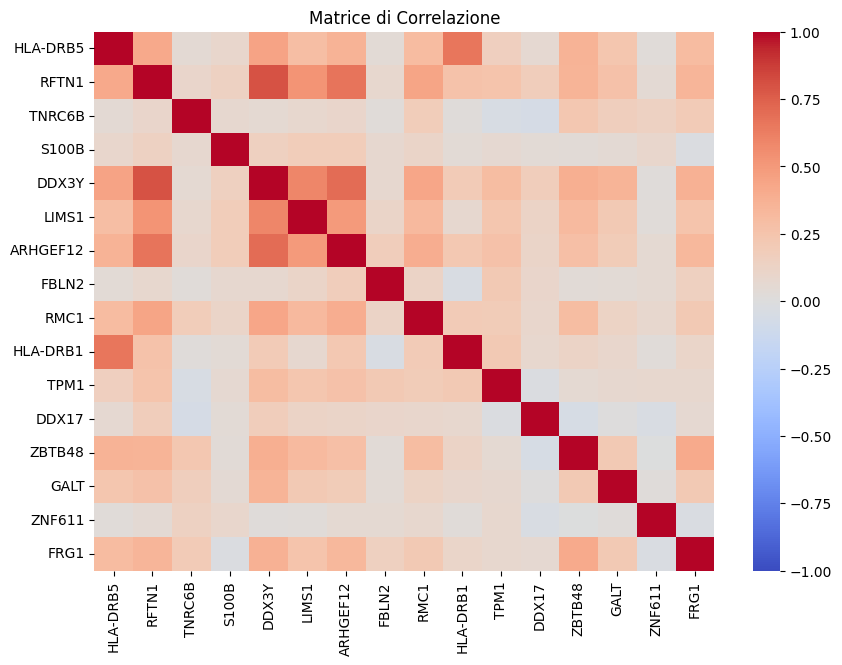

In [20]:
intersect = set(list(expl_sorted.keys())[:100]) & set(bestFeatures.keys())

print(intersect)

intersectCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(intersect)].corr()

plt.figure(figsize=(10,7))
sns.heatmap(intersectCorr, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matrice di Correlazione')
plt.show()

In [21]:
intersect_correlated_pairs = np.where(np.abs(intersectCorr) >= 0.4)

# Print the correlated pairs
for i, j in zip(intersect_correlated_pairs[0], intersect_correlated_pairs[1]):
    if i != j:
        print(f"{intersectCorr.index[i]} - {intersectCorr.columns[j]}: {intersectCorr.iloc[i, j]}")

HLA-DRB5 - RFTN1: 0.4159582130968884
HLA-DRB5 - DDX3Y: 0.44870776622522096
HLA-DRB5 - HLA-DRB1: 0.657987584132758
RFTN1 - HLA-DRB5: 0.4159582130968884
RFTN1 - DDX3Y: 0.8009619061046651
RFTN1 - LIMS1: 0.5298155206049963
RFTN1 - ARHGEF12: 0.671486064924982
RFTN1 - RMC1: 0.44390862235498907
DDX3Y - HLA-DRB5: 0.44870776622522096
DDX3Y - RFTN1: 0.8009619061046651
DDX3Y - LIMS1: 0.589936533673424
DDX3Y - ARHGEF12: 0.7004801930462589
DDX3Y - RMC1: 0.43285401219220904
LIMS1 - RFTN1: 0.5298155206049963
LIMS1 - DDX3Y: 0.589936533673424
LIMS1 - ARHGEF12: 0.49968147398826224
ARHGEF12 - RFTN1: 0.671486064924982
ARHGEF12 - DDX3Y: 0.7004801930462589
ARHGEF12 - LIMS1: 0.49968147398826224
RMC1 - RFTN1: 0.44390862235498907
RMC1 - DDX3Y: 0.43285401219220904
HLA-DRB1 - HLA-DRB5: 0.657987584132758
ZBTB48 - FRG1: 0.4068803557818458
FRG1 - ZBTB48: 0.4068803557818458


<h1>Biogrid graph</h1>

In [5]:
os.chdir("../../scriptPython/DatasetFull")

def load_files_to_dataframes(directory, geneList, file_extension='.txt'):
    dataframes = {}
    
    for name in geneList:
        print(name)
        filename = name+'.tab3.txt'
        if filename in os.listdir(directory):
            print("File presente, caricamento in corso...")
            if filename.endswith(file_extension):
                file_path = os.path.join(directory, filename)
        else:
            print("File non presente")
            scrape.main(name)

        df = pd.read_csv(file_path, delimiter='\t')[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
        df['Interaction'] = df.apply(
        lambda row: '_'.join(sorted([row['Official Symbol Interactor A'], row['Official Symbol Interactor B']])), axis=1)
        dataframes[filename] = df

    return dataframes

Grafo con i migliori geni ottenuti da shapValues

DDX3Y
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
HLA-DRB5
File presente, caricamento in corso...
GALT
File presente, caricamento in corso...
FBLN2
File presente, caricamento in corso...
MAP3K11
File presente, caricamento in corso...
FRG1
File presente, caricamento in corso...
HNRNPA1
File presente, caricamento in corso...
RFTN1
File presente, caricamento in corso...
LIMS1
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
BLCAP
File presente, caricamento in corso...
CALML4
File presente, caricamento in corso...
ZBTB48
File presente, caricamento in corso...
STARD7
File presente, caricamento in corso...
RMC1
File presente, caricamento in corso...
CS
File presente, caricamento in corso...
ARHGEF12
File presente, caricamento in corso...
SLC23A2
File presente, caricamento in corso...
ABR
File presente, caricamento in corso...
CXCL2
File presente, caricamento in corso...
CLU
File presente, caricamento in corso...
RH

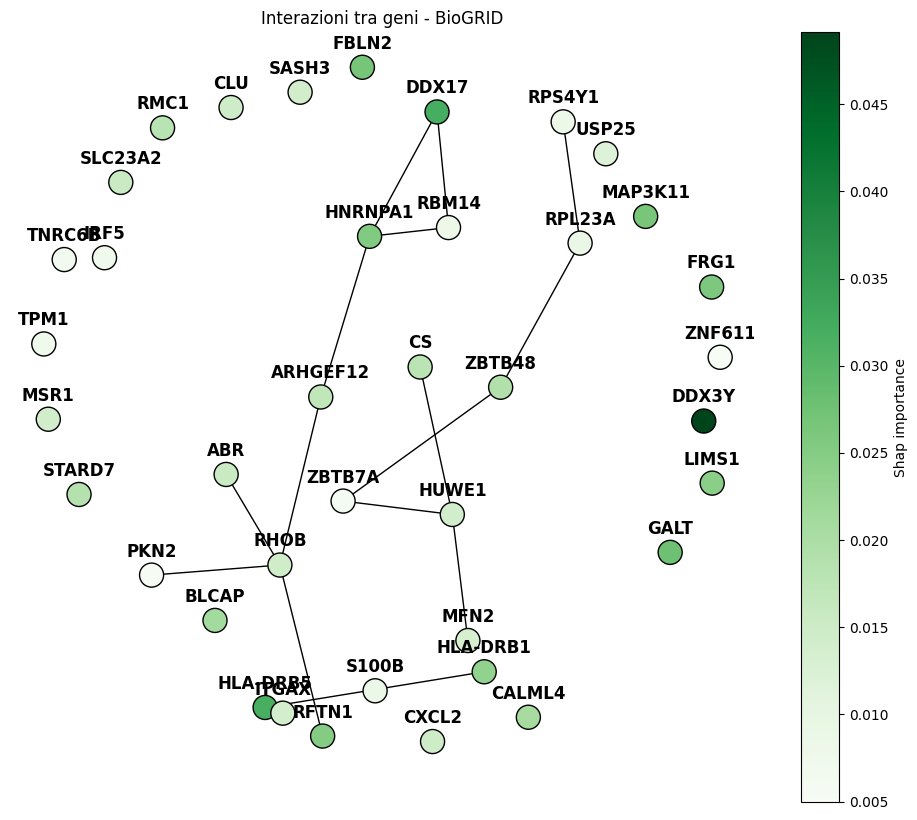

In [46]:
geneList = list(expl_sorted.keys())[:]
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList and gene_a != gene_b:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.7)
fig, ax = plt.subplots(figsize=(12,10))
# nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors, node_size=2500,
#                  font_color='black', edgecolors = 'black', font_weight='bold',font_size='9')

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con i migliori geni ablation

HLA-DRB5
File presente, caricamento in corso...
FBLN2
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
TPM1
File presente, caricamento in corso...
ZNF611
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
RFTN1
File presente, caricamento in corso...
LIMS1
File presente, caricamento in corso...
S100B
File presente, caricamento in corso...
RMC1
File presente, caricamento in corso...
ARHGEF12
File presente, caricamento in corso...
GALT
File presente, caricamento in corso...
FRG1
File presente, caricamento in corso...
ZBTB48
File presente, caricamento in corso...
TNRC6B
File presente, caricamento in corso...


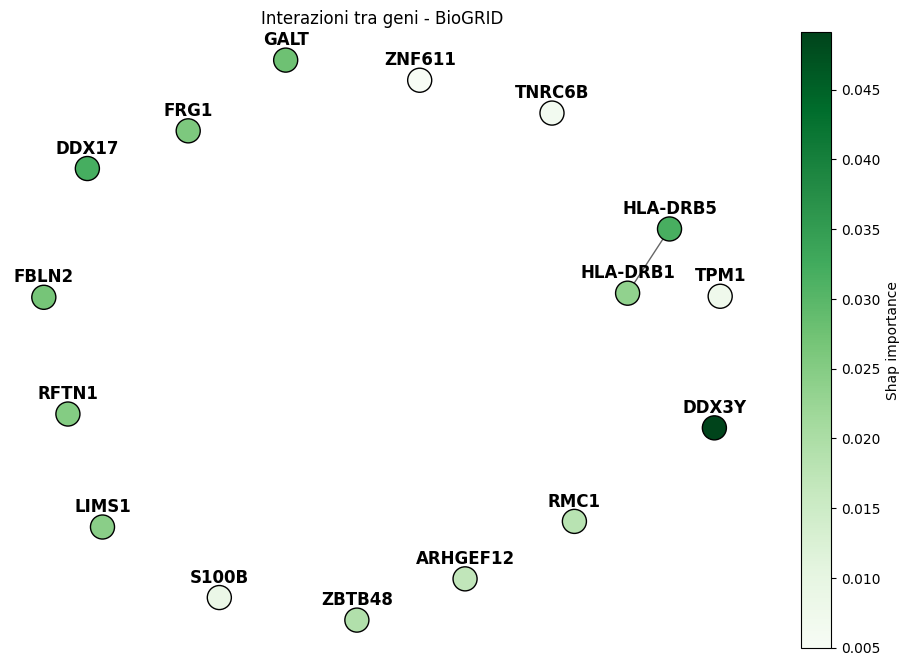

In [35]:
geneList = list(bestFeatures.keys())
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []

i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)
    
for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con intersezione tra i migliori shapValues e i migliori ablation

In [36]:
goodIntersect = set(list(expl_sorted.keys())[:]).intersection(set(list(bestFeatures.keys())))
evilIntersect = set(list(expl_sorted.keys())[:]).intersection(set(list(worstFeatures.keys())))
                                                                
print(goodIntersect)
print(evilIntersect)

{'HLA-DRB5', 'RFTN1', 'TNRC6B', 'S100B', 'DDX3Y', 'LIMS1', 'ARHGEF12', 'FBLN2', 'RMC1', 'HLA-DRB1', 'TPM1', 'DDX17', 'ZBTB48', 'GALT', 'ZNF611', 'FRG1'}
{'HUWE1', 'MFN2', 'HNRNPA1'}


HLA-DRB5
File presente, caricamento in corso...
RFTN1
File presente, caricamento in corso...
TNRC6B
File presente, caricamento in corso...
S100B
File presente, caricamento in corso...
DDX3Y
File presente, caricamento in corso...
LIMS1
File presente, caricamento in corso...
ARHGEF12
File presente, caricamento in corso...
FBLN2
File presente, caricamento in corso...
RMC1
File presente, caricamento in corso...
HLA-DRB1
File presente, caricamento in corso...
TPM1
File presente, caricamento in corso...
DDX17
File presente, caricamento in corso...
ZBTB48
File presente, caricamento in corso...
GALT
File presente, caricamento in corso...
ZNF611
File presente, caricamento in corso...
FRG1
File presente, caricamento in corso...


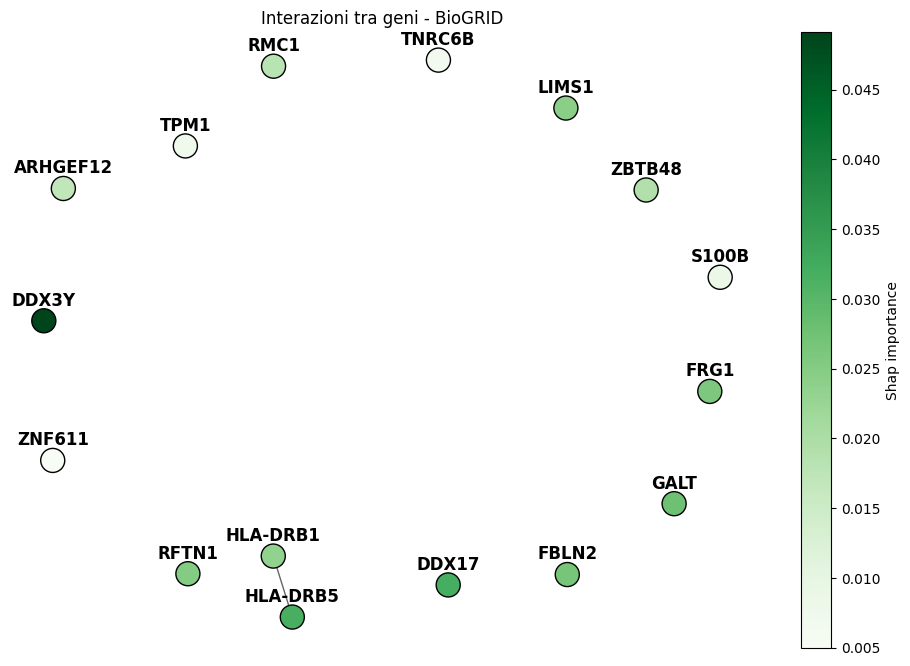

In [39]:
geneList = list(goodIntersect)
dataframes = load_files_to_dataframes('./biogridFile', geneList)

merged_dataframes = []


i = 0
for df1, df2 in combinations(list(dataframes.values()), 2):
    merged_df = pd.merge(df1, df2, on='Interaction')[['Official Symbol Interactor A_x', 'Official Symbol Interactor B_x']]
    merged_df.columns = ['InteractorA', 'InteractorB']
    merged_dataframes.append(merged_df)

concatenated_df = pd.concat(merged_dataframes, ignore_index=True)
concatenated_df.drop_duplicates(inplace=True)

# Crea un grafo non orientato
G = nx.Graph()

for node in geneList:
    G.add_node(node)

for index, row in concatenated_df.iterrows():
    gene_a = row['InteractorA']
    gene_b = row['InteractorB']
    if gene_a in geneList and gene_b in geneList:
        G.add_edge(gene_a, gene_b)

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.6)
fig, ax = plt.subplots(figsize=(12,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - BioGRID')
plt.axis('off')
plt.show()

Grafo con interazioni matrice di correlazione migliori 100 shap importance

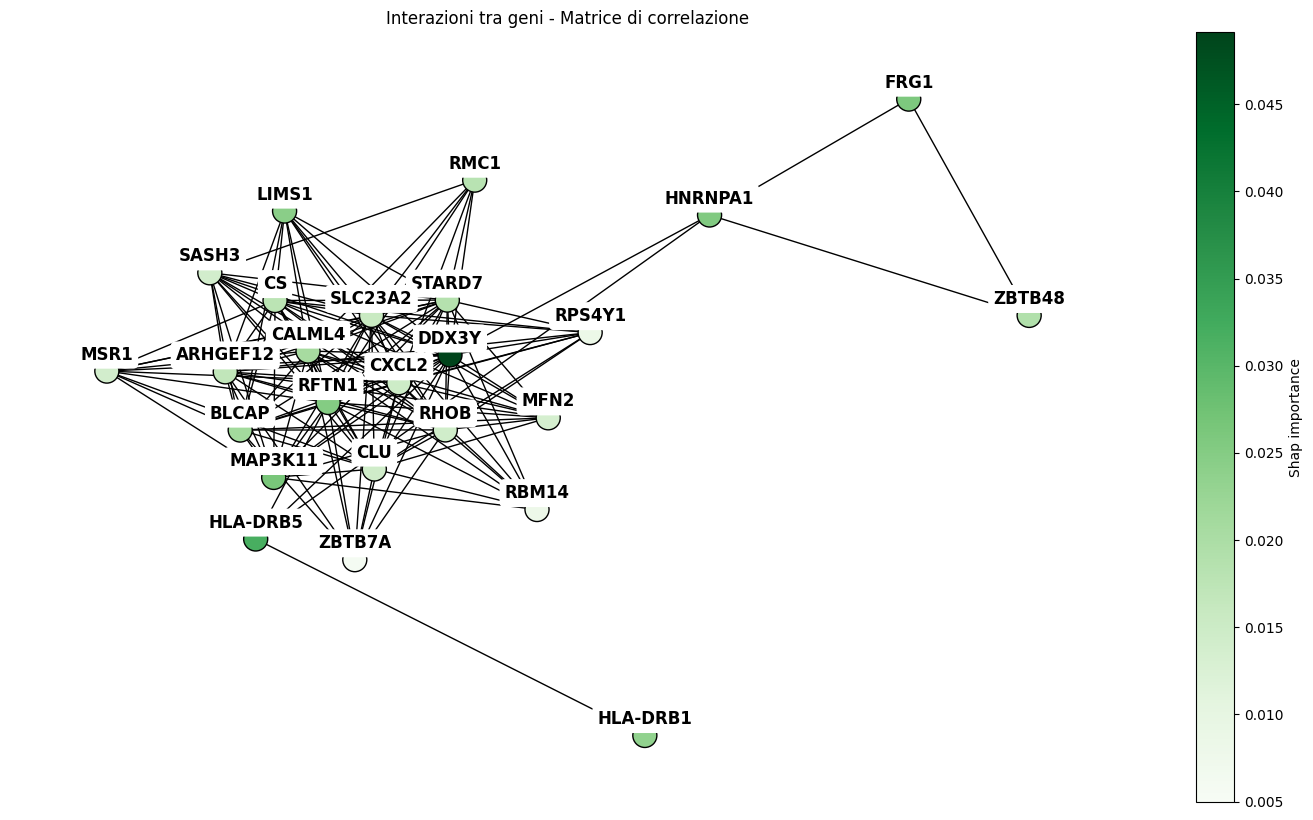

In [130]:
ensembleCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(expl_sorted.keys())[:100]].corr()

G = nx.Graph()

for i in range(ensembleCorr.shape[0]):
    for j in range(ensembleCorr.shape[1]):
        if abs(ensembleCorr.iloc[i, j]) > 0.4 and i != j:
            G.add_edge(ensembleCorr.columns[i], ensembleCorr.columns[j])

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]
pos = nx.spring_layout(G, k=1)
fig, ax = plt.subplots(figsize=(18,10))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.04) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Disegna gli archi
nx.draw_networkx_edges(G, pos, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()

Grafo ottenuto da matrice di correlazione con intersezione migliori geni SHAP e ablation

{'HLA-DRB5', 'RFTN1', 'TNRC6B', 'S100B', 'DDX3Y', 'LIMS1', 'ARHGEF12', 'FBLN2', 'RMC1', 'HLA-DRB1', 'TPM1', 'DDX17', 'ZBTB48', 'GALT', 'ZNF611', 'FRG1'}
          HLA-DRB5     RFTN1    TNRC6B     S100B     DDX3Y     LIMS1  \
HLA-DRB5  1.000000  0.415958  0.050476  0.088322  0.448708  0.296628   
RFTN1     0.415958  1.000000  0.096009  0.143642  0.800962  0.529816   
TNRC6B    0.050476  0.096009  1.000000  0.077231  0.058068  0.081701   
S100B     0.088322  0.143642  0.077231  1.000000  0.151770  0.182081   
DDX3Y     0.448708  0.800962  0.058068  0.151770  1.000000  0.589937   
LIMS1     0.296628  0.529816  0.081701  0.182081  0.589937  1.000000   
ARHGEF12  0.362214  0.671486  0.098461  0.186328  0.700480  0.499681   
FBLN2     0.040502  0.083333  0.023869  0.076329  0.075174  0.116893   
RMC1      0.311470  0.443909  0.185451  0.111537  0.432854  0.322937   
HLA-DRB1  0.657988  0.258866  0.021748  0.044657  0.196876  0.070648   
TPM1      0.162960  0.250475 -0.043570  0.067046  0.302

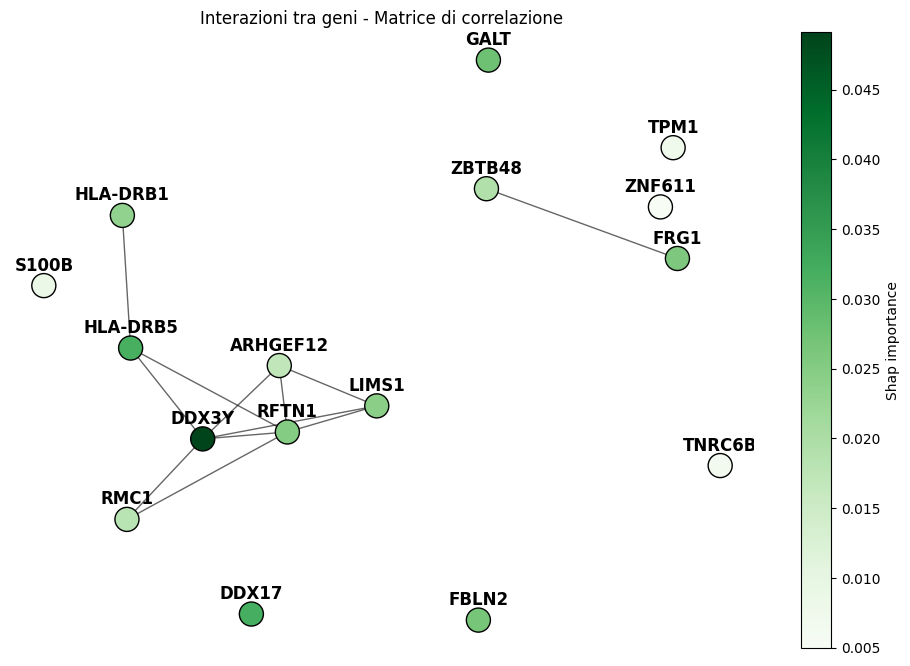

In [128]:
intersect = set(list(bestFeatures.keys())).intersection(set(list(expl_sorted.keys())[:]))

print(intersect)

intersectCorr = pd.DataFrame(shap_values, columns=x_train.columns)[list(intersect)].corr()

print(intersectCorr)

G = nx.Graph()

for i in range(intersectCorr.shape[0]):
    G.add_node(intersectCorr.columns[i])
    for j in range(intersectCorr.shape[1]):
        if abs(intersectCorr.iloc[i, j]) >= 0.4 and i != j:
            print(intersectCorr.columns[i], intersectCorr.columns[j])
            G.add_edge(intersectCorr.columns[i], intersectCorr.columns[j])

# Disegna il grafo
norm = plt.Normalize(vmin=min(expl_sorted.values()), vmax=max(expl_sorted.values()))
cmap = cm.Greens
node_colors = [cmap(norm(expl_sorted[node])) for node in G.nodes()]

pos = nx.spring_layout(G, k=0.8)
fig, ax = plt.subplots(figsize=(12,8))

# Disegna i nodi con il contorno nero
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=300, edgecolors='black', linewidths=1)

# Crea un offset per spostare le etichette sopra i nodi
label_pos = {node: (pos[node][0], pos[node][1] + 0.07) for node in G.nodes()}

# Disegna le etichette sopra i nodi
nx.draw_networkx_labels(G, label_pos, font_color='black', font_size=12, font_weight='bold', ax=ax)

# Disegna gli archi
nx.draw_networkx_edges(G, pos, alpha=0.6, ax=ax)

# Aggiungi la barra dei colori
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Shap importance", ax=ax)
plt.title('Interazioni tra geni - Matrice di correlazione')
plt.axis('off')
plt.show()